In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision import transforms
import zookeeper as zk
import os
from tqdm import tqdm
from PIL import Image
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('spada e s' + str(device))

mappy = False ### if the Net isn't mapped
rgb = False

spada e scuda


In [3]:
class GalaxyJungle(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, mappy=False, is_rgb=False):
        self.rgb = is_rgb
        self.mappy = mappy
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        
    
    def __len__(self): return (self.img_labels).shape[0]

    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0])) + '.jpg'
        image = Image.open(img_path)
        if not self.rgb: image = image.convert('L')
        if self.transform: image = self.transform(image)
        
        label = self.img_labels.iloc[idx, 1:]        
        label = torch.tensor(label.values, dtype=torch.float32)
        if self.mappy: label = zk.mappy(label)

        gal_id = self.img_labels.iloc[idx, 0]

        return image, label, gal_id

In [4]:
class GalaxyNet(nn.Module):
    def __init__(self, activation, initialization=False, mappy=False, is_rgb=False):
        super().__init__()
        
        self.mappy = mappy
        rgb = 3 if is_rgb else 1
        input_size = 128
        num_labels = 37
        self.loss_dict = {'batch' : [], 'epoch' : [], 'vbatch' : [], 'vepoch' : []}
        self.activation = activation
        
        self.convs = nn.Sequential(
            nn.Conv2d(rgb, 16, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(16),
            
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(128),

            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(256),

            nn.MaxPool2d(2)
            )

        for layer in self.convs:
            if layer.__class__.__name__ == 'Conv2d': input_size = zk.convool_size(input_size, 3, 1, 'same' if layer.padding == 'same' else 0)
            elif layer.__class__.__name__ == 'MaxPool2d': input_size = zk.convool_size(input_size, 2, 2)

        if input_size < 2: raise ValueError('You shrank too much dude.')
        print(f'Convs output size: {input_size}')

        input_linear = 256 * input_size * input_size
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_linear, 100),
            self.activation(),
            nn.Linear(100, num_labels)
            )
        
        if initialization: self.init_weights()


    def forward(self, x):
        x = self.convs(x)
        x = self.fc(x)
        if self.mappy: x = zk.mappy2D(x)
        return x


    def init_weights(self):
        if self.activation == nn.ReLU:
            nonlin = 'relu'
            a = 0
        elif self.activation == nn.LeakyReLU:
            nonlin = 'leaky_relu'
            a = .01
        
        for layer in self.convs: 
            if layer.__class__.__name__ == 'Conv2d': nn.init.kaiming_normal_(layer.weight, a=a, nonlinearity=nonlin)        

        for i in (1, -1): nn.init.constant_(self.fc[i].bias, 0)
 
        nn.init.kaiming_normal_(self.fc[1].weight, a=a, nonlinearity=nonlin)
        nn.init.xavier_uniform_(self.fc[-1].weight)      
        

    def log_the_loss(self, item,epoch=False):
        train = self.__getstate__()['training']
        if epoch and train:
            self.loss_dict['epoch'].append(item)
        elif not epoch and train:
            self.loss_dict['batch'].append(item)
        elif not train and epoch:
            self.loss_dict['vepoch'].append(item)
        elif not train and not epoch:
            self.loss_dict['vbatch'].append(item)
        return item


In [5]:
model = GalaxyNet(nn.LeakyReLU, initialization=False, mappy=False, is_rgb=rgb).to(device)
loss_function = nn.MSELoss()

## NOTE: the loss_dict will be empty, remember which is the last loss_{}.pickle file of previous trainings to append the values all together
loader = torch.load('/home/teobaldo/Uni/LCP-B/proj/Padel_final/model_optim_110.pt', weights_only=True)
model.load_state_dict(loader['model_state_dict'])

Convs output size: 2


<All keys matched successfully>

In [18]:
model = GalaxyNet(nn.LeakyReLU, initialization=False, mappy=False, is_rgb=rgb).to(device)
loss_function = nn.MSELoss()

## NOTE: the loss_dict will be empty, remember which is the last loss_{}.pickle file of previous trainings to append the values all together
loader = torch.load('/home/teobaldo/Uni/LCP-B/proj/PADELSCORE/model.pt', weights_only=True)
model.load_state_dict(loader)

Convs output size: 2


<All keys matched successfully>

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(), # Riscala le immagini tra 0 e 1
    transforms.CenterCrop(324),
    transforms.Resize(128),
])

DS = GalaxyJungle('../data/test/test_solutions_rev1.csv', '../data/test/', transform, mappy=True, is_rgb=rgb)
test_loader = DataLoader(DS, batch_size=512, shuffle=False, num_workers=os.cpu_count())   

tens=torch.empty((0,18),dtype=torch.float32)

model.eval()
loss = 0
with torch.no_grad():
        for i, vdata in tqdm(enumerate(test_loader)):
            inputs,labels, GalaxyID = vdata
            inputs,labels= inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = nn.ReLU()(outputs)
            outputs = zk.mappy2D(outputs)
            loss += np.sqrt(nn.MSELoss()(outputs, labels).item())
            GalaxyID = GalaxyID.unsqueeze(1)
            batch = torch.cat((GalaxyID,outputs.cpu()), dim=-1)
            tens = torch.cat((tens,batch),dim=0)
print('Test loss', loss/len(test_loader))

13it [00:14,  1.12s/it]

Test loss 0.060448818232772705


In [7]:
training_sample = zk.mappy_df(pd.read_csv('../data/validation/validation_solutions_rev1.csv'))
training_sample['train_label'] = training_sample.iloc[:,1:].idxmax(axis=1)
training_sample['train_value'] = training_sample.iloc[:,1:-1].max(axis=1)
display(training_sample[training_sample['train_value'] > .5].groupby('train_label').size())

/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/zookeeper.py:187: RuntimeWarning: invalid value encountered in divide
  class4_2 / class4_2.sum(axis=1, keepdims=True),
/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/zookeeper.py:190: RuntimeWarning: invalid value encountered in divide
  class5_4 / class5_4.sum(axis=1, keepdims=True),


train_label
A              7
E0          1563
E3          1454
E6            99
S0a_eon      315
SAb           40
SAc          219
SAd            1
SB0a_eon       5
SBb           25
SBc           19
Scd_eon      133
SoA          561
SoB           74
dtype: int64

In [8]:
training_sample = zk.mappy_df(pd.read_csv('../data/training/training_solutions_rev1.csv'))

training_sample['train_label'] = training_sample.iloc[:,1:].idxmax(axis=1)
training_sample['train_value'] = training_sample.iloc[:,1:-1].max(axis=1)
display(training_sample[training_sample['train_value'] > .5].groupby('train_label').size())

/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/zookeeper.py:187: RuntimeWarning: invalid value encountered in divide
  class4_2 / class4_2.sum(axis=1, keepdims=True),
/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/zookeeper.py:190: RuntimeWarning: invalid value encountered in divide
  class5_4 / class5_4.sum(axis=1, keepdims=True),


train_label
A             32
E0          5997
E3          5854
E6           424
S0a_eon     1383
SAa            1
SAb          207
SAc          781
SAd           10
SB0a_eon      23
SBb          115
SBc          130
SBd            3
Scd_eon      590
SoA         2148
SoB          290
dtype: int64

In [9]:
train_results = pd.DataFrame(tens, columns=['GalaxyID','E0','E3','E6','S0a_eon','SB0a_eon','Scd_eon','SoB','SoA','SAa','SAb','SAc','SAd','SBa','SBb','SBc','SBd','A'])
train_results[train_results < 0] = 0
train_results['GalaxyID'] = train_results['GalaxyID'].astype(int)
train_results.sort_values('GalaxyID', inplace=True, ignore_index=True)

true_results = zk.mappy_df(pd.read_csv('../data/test/test_solutions_rev1.csv'))
true_results.sort_values('GalaxyID', inplace=True, ignore_index=True)


train_results['train_label'] = train_results.iloc[:,1:].idxmax(axis=1)
train_results['train_value'] = train_results.iloc[:,1:-1].max(axis=1)

true_results['true_label'] = true_results.iloc[:,1:].idxmax(axis=1)
true_results['true_value'] = true_results.iloc[:,1:-1].max(axis=1)

/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/zookeeper.py:187: RuntimeWarning: invalid value encountered in divide
  class4_2 / class4_2.sum(axis=1, keepdims=True),
/home/teobaldo/Uni/LCP-B/proj/GalaxyClassifier/zookeeper.py:190: RuntimeWarning: invalid value encountered in divide
  class5_4 / class5_4.sum(axis=1, keepdims=True),


In [ ]:
true_new = true_results
# true_new = true_results[true_results['true_value'] > 0.6]
#train_new=train_results[train_results['train_value'] > 0.4]
confronto=pd.merge(train_results[['GalaxyID','train_label']], true_new[['GalaxyID','true_label']], on='GalaxyID')
total_count=confronto.groupby('true_label').size().reset_index(name='total_count')
mislabels = confronto[confronto['train_label'] != confronto['true_label']]

count=mislabels.groupby('true_label').size().reset_index(name='num_misclassified').sort_values(by='num_misclassified', ascending=False)
final_count= pd.merge(total_count, count, on='true_label', how='left').sort_values(by='num_misclassified', ascending=False)
final_count['score'] = (np.round((1 - final_count['num_misclassified'] / final_count['total_count']),2)*100)
final_count.sort_values(by='score', ascending=False, inplace=True)
display(final_count)

,true_label,total_count,num_misclassified,score
1,E0,1273,104,92.0
0,A,11,1,91.0
2,E3,1537,264,83.0
7,SAc,531,149,72.0
4,S0a_eon,408,116,72.0
3,E6,290,105,64.0
14,Scd_eon,169,71,58.0
6,SAb,278,143,49.0
12,SBc,116,65,44.0
11,SBb,143,80,44.0


In [90]:
class FuckingNewTest(Dataset):
    def __init__(self, img_dir, transform, mappy=False):
        self.mappy = mappy
        self.img_dir = img_dir
        self.transform = transform
        self.data = []
        with os.scandir(img_dir) as dir:
            for file in dir:
                self.data.append(file.name)
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data[idx])
        image = Image.open(img_path).convert('L')
        if self.transform: image = self.transform(image)
        return image, int(self.data[idx][:-4])
    
    def __len__(self):
        return len(self.data)

In [91]:
NDS = FuckingNewTest('../data/stoopid_test', transform)
test_loader = DataLoader(NDS, batch_size=1024, shuffle=False, num_workers=os.cpu_count())   

next(iter(test_loader))[1].type()


'torch.LongTensor'

In [92]:
transform = transforms.Compose([
    transforms.ToTensor(), # Riscala le immagini tra 0 e 1
    transforms.CenterCrop(324),
    transforms.Resize(128),
])

NDS = FuckingNewTest('../data/stoopid_test', transform)
test_loader = DataLoader(NDS, batch_size=1024, shuffle=False, num_workers=os.cpu_count())   

tens=torch.empty((0,18),dtype=torch.float32)

model.eval()
with torch.no_grad():
        for i, vdata in tqdm(enumerate(test_loader)):
            inputs, GalaxyID = vdata
            inputs = inputs.to(device)
            outputs = model(inputs)
            outputs = nn.ReLU()(outputs)
            outputs = zk.mappy2D(outputs)
            GalaxyID = GalaxyID.unsqueeze(1)
            batch = torch.cat((GalaxyID, outputs.cpu()), dim=-1)
            tens = torch.cat((tens,batch),dim=0)

79it [01:13,  1.07it/s]


In [94]:
train_results = pd.DataFrame(tens, columns=['GalaxyID','E0','E3','E6','S0a_eon','SB0a_eon','Scd_eon','SoB','SoA','SAa','SAb','SAc','SAd','SBa','SBb','SBc','SBd','A'])
train_results[train_results < 0] = 0
train_results['GalaxyID'] = train_results['GalaxyID'].astype(int)
train_results.sort_values('GalaxyID', inplace=True, ignore_index=True)


train_results['train_label'] = train_results.iloc[:,1:].idxmax(axis=1)
train_results['train_value'] = train_results.iloc[:,1:-1].max(axis=1)

In [121]:
train_results.sample(5)

,GalaxyID,E0,E3,E6,S0a_eon,SB0a_eon,Scd_eon,SoB,SoA,SAa,SAb,SAc,SAd,SBa,SBb,SBc,SBd,A,train_label,train_value
45314,606363,0.016082,0.000000,0.005154,0.004375,0.000000,0.011105,0.000000,0.000000,0.001735,0.135907,0.218259,0.005860,0.003065,0.240129,0.385634,0.010354,0.006341,SBc,0.385634
32071,458753,0.553884,0.189923,0.003635,0.017117,0.000000,0.002856,0.013699,0.134874,0.013902,0.006090,0.016822,0.017429,0.001412,0.000619,0.001709,0.001770,0.034231,E0,0.553884
10921,222922,0.042265,0.010954,0.000984,0.009344,0.000000,0.028718,0.072207,0.679105,0.019440,0.105753,0.016256,0.000822,0.002067,0.011244,0.001728,0.000087,0.007938,SoA,0.679105
9841,211238,0.036442,0.124068,0.020103,0.037592,0.010617,0.019687,0.041264,0.218555,0.049236,0.196314,0.148537,0.026418,0.009296,0.037065,0.028044,0.004988,0.000000,SoA,0.218555
57541,745507,0.055570,0.619737,0.016899,0.019274,0.000000,0.008604,0.047090,0.161050,0.005042,0.025141,0.009344,0.000000,0.001474,0.007351,0.002732,0.000000,0.021131,E3,0.619737


E6
E3
E0
SAc
A
SoA


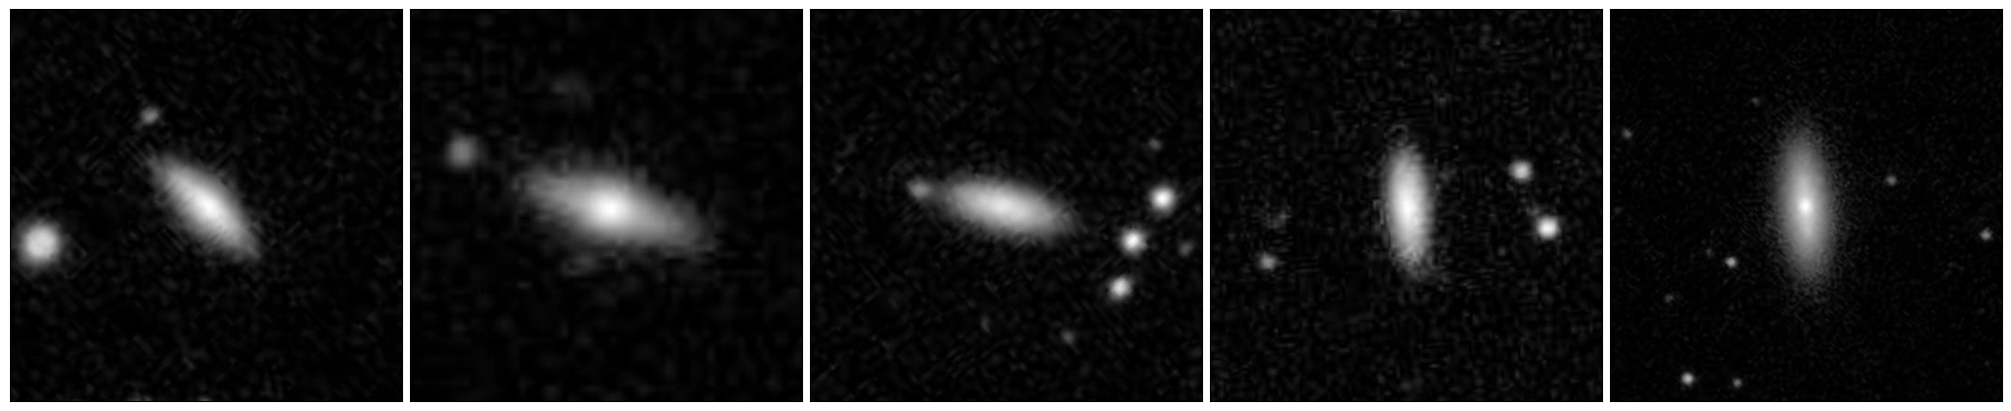

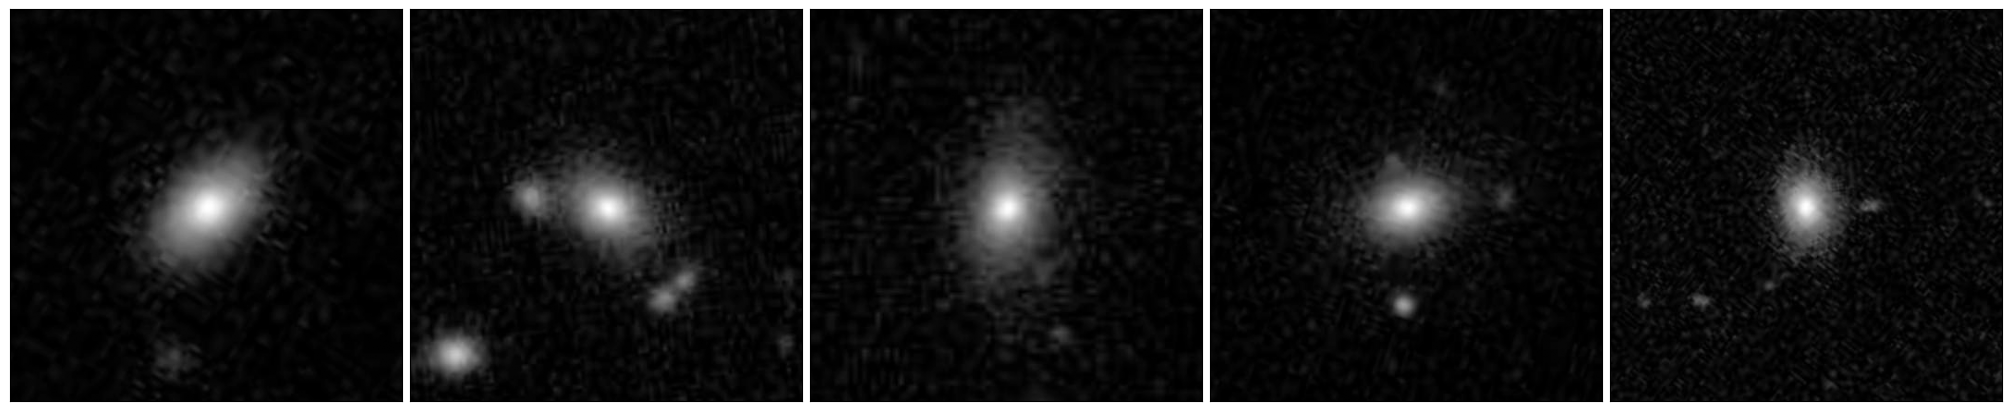

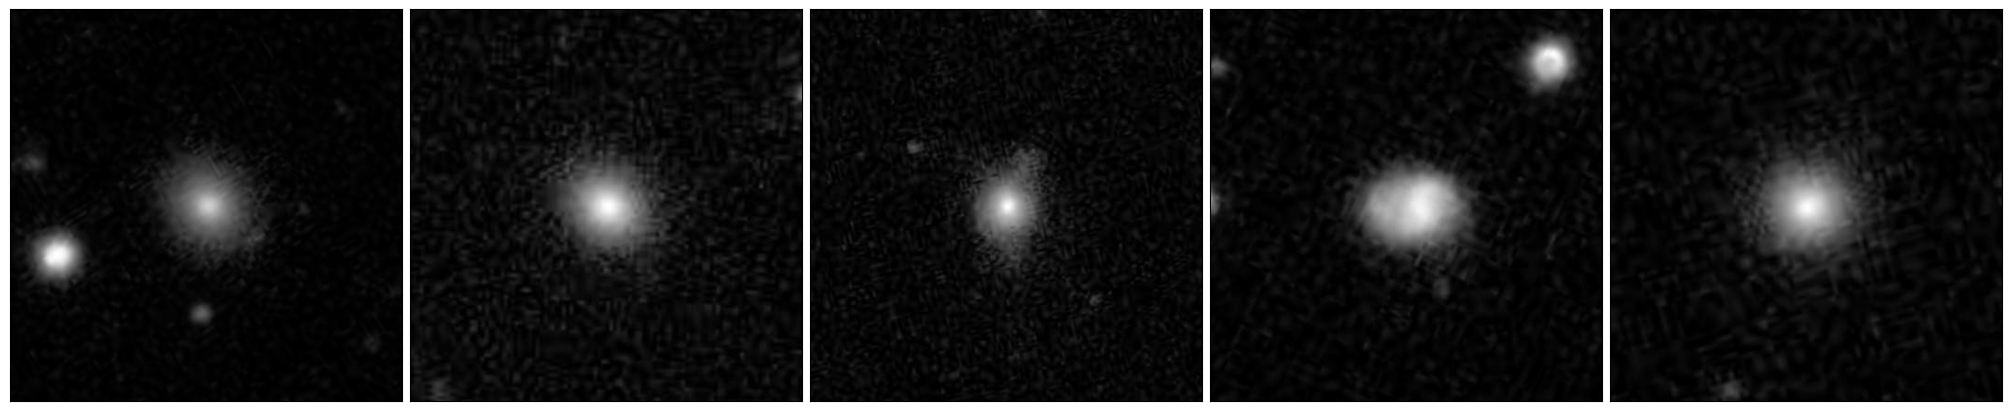

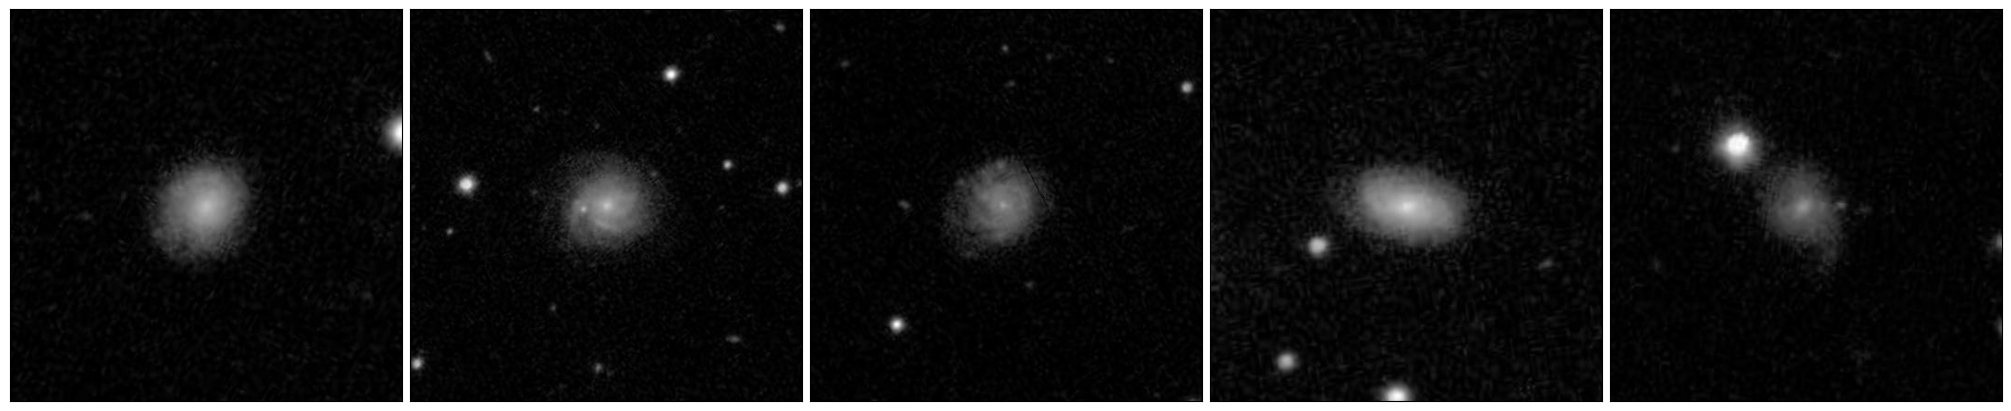

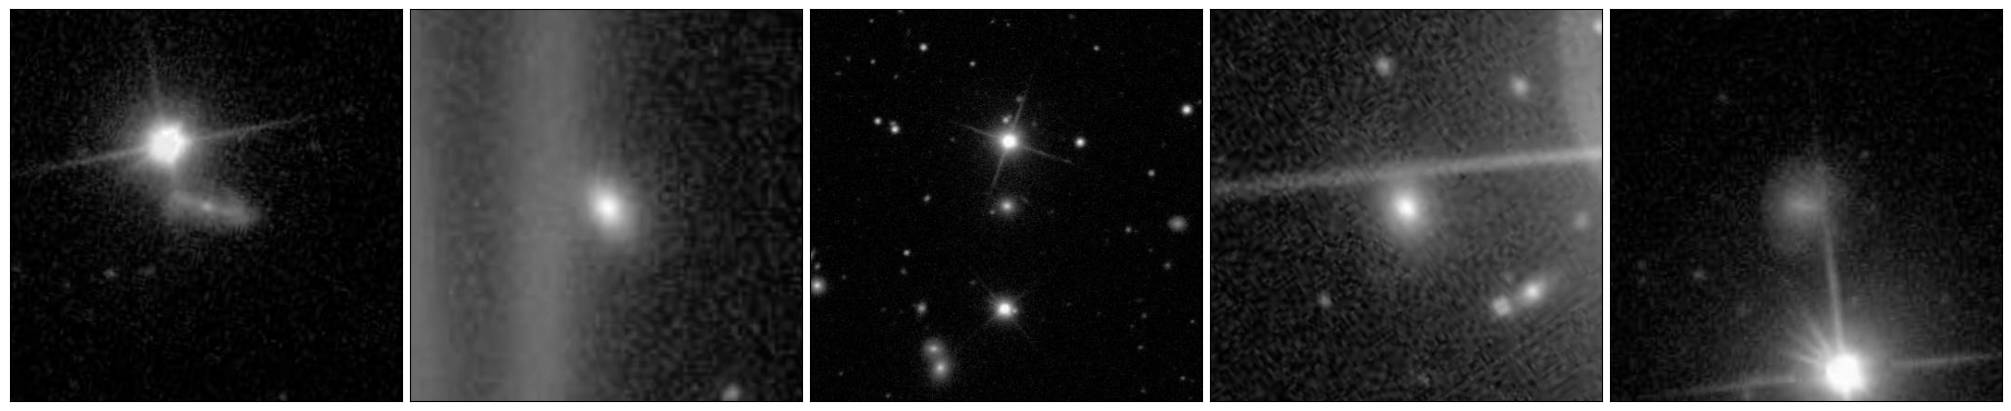

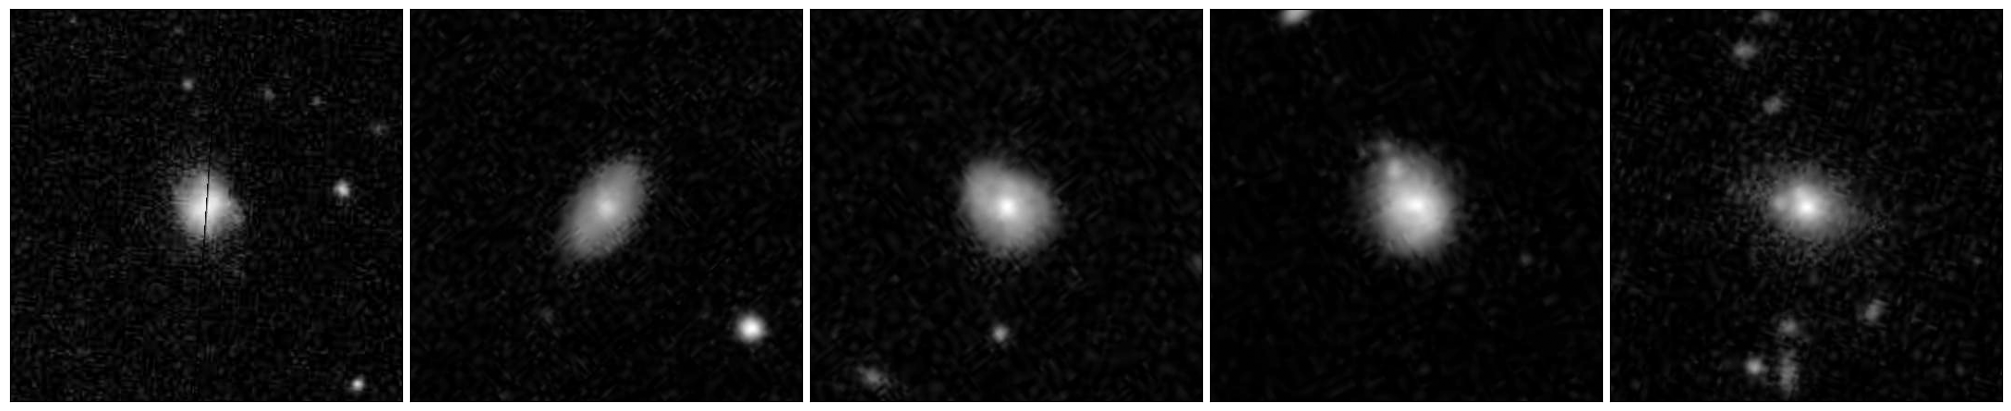

In [131]:
import matplotlib.pyplot as plt

gal_type = ['E6', 'E3', 'E0', 'SAc', 'A', 'SoA']
gal_num = 5
ids = []
for id in gal_type: ids.append(train_results[train_results['train_label'] == id].sample(gal_num)['GalaxyID'].to_numpy())

for j, Type in enumerate(gal_type):
    print(Type)
    fig, Ax = plt.subplots(1, gal_num, figsize=(20, 8), layout='constrained')
    for i, ax in enumerate(Ax):
        ax.set_aspect('equal', 'box')
        ax.imshow(Image.open('../data/stoopid_test/' +  str(ids[j][i]) + '.jpg').convert('L'), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()

In [16]:
x=confronto.groupby(['true_label','train_label']).count()
pd.set_option('display.max_rows', None)
display(x)

GalaxyID
true_label train_label          
A          E0                  2
E0         E0                598
           E3                  3
           SAc                 1
           SoA                 2
           SoB                 1
E3         E0                 19
           E3                413
           SAc                 1
           SoA                 6
E6         E3                  1
           E6                 10
           S0a_eon             1
           Scd_eon             2
S0a_eon    E3                  2
           E6                  6
           S0a_eon            90
           SAb                 1
           Scd_eon             4
SAb        SAb                 6
           SAc                 2
           SoA                 2
SAc        E3                  1
           SAb                 1
           SAc                36
           SoA                 2
SBb        SBb                 2
           SoA                 1
           SoB                 1
SBc        SAc                 3
           SBb                 3
           SBc                 4
Scd_eon    E6                  1
           S0a_eon             2
           SBc                 1
           SBd                 1
           Scd_eon            34
SoA        E0                 20
           E3                 16
           SAc                 1
           SoA                41
SoB        E0                  1
           E3                  3
           SBb                 1
           SoB                17